In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')

In [2]:
from pycalphad.fitting import setup_dataset
from pycalphad import Database, calculate
import pymc
import numpy as np
import glob

input_database = Database('Al-Ni/Al-Ni-start.tdb')
dataset_names = sorted(glob.glob('Al-Ni/*.json'))
# Better to do this as a list or dict of namedtuple once it's modularized
dataset_exps = []
dataset_error_funcs = []
dataset_calc_funcs = []

FCCBMAGNNI = pymc.Gamma('FCCBMAGNNI', alpha=1, beta=1)
FCCTCALNI0 = pymc.Normal('FCCTCALNI0', mu=0, tau=1./2000**2)
FCCTCALNI1 = pymc.Normal('FCCTCALNI1', mu=0, tau=1./2000**2)
params = [FCCBMAGNNI, FCCTCALNI0, FCCTCALNI1]
dataset_variance = pymc.Gamma('dataset_variance',
                              alpha=np.full_like(dataset_names, 0.1, dtype=np.float),
                              beta=np.full_like(dataset_names, 0.1, dtype=np.float),
                              size=len(dataset_names))

e = []
for idx, fname in enumerate(dataset_names):
    with open(fname) as file_:
        error, calc_func, exp_data = setup_dataset(file_, input_database, params)
        dataset_error_funcs.append(error)
        dataset_calc_funcs.append(calc_func)
        dataset_exps.append(exp_data)

@pymc.potential
def error(FCCBMAGNNI=FCCBMAGNNI, FCCTCALNI0=FCCTCALNI0, FCCTCALNI1=FCCTCALNI1):
    result = np.zeros_like(dataset_names, dtype=np.float)
    for idx in range(len(dataset_names)):
        result[idx] = np.square(dataset_error_funcs[idx](FCCBMAGNNI, FCCTCALNI0, FCCTCALNI1)).mean() / dataset_variance[idx]
    return -result.sum()

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
mod = pymc.Model(params + [dataset_variance, error])
#map_ = pymc.MAP(mod).fit()
MDL = pymc.MCMC(mod)
%time MDL.sample(iter=10000, burn=0, burn_till_tuned=False, thin=2, progress_bar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 295.6 secCPU times: user 4min 55s, sys: 448 ms, total: 4min 55s
Wall time: 4min 55s


Plotting FCCTCALNI0
Plotting FCCTCALNI1
Plotting FCCBMAGNNI
Plotting dataset_variance
Plotting dataset_variance_0


/home/rotis/anaconda/envs/mc/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


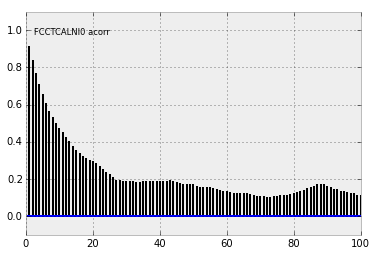

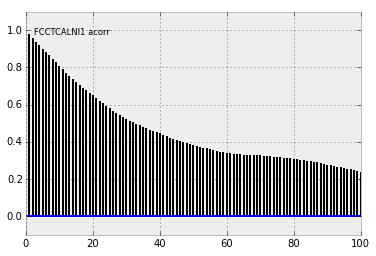

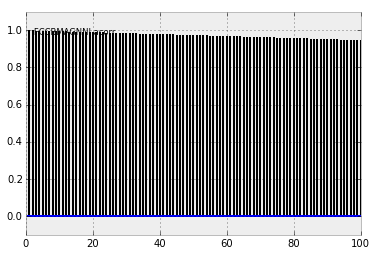

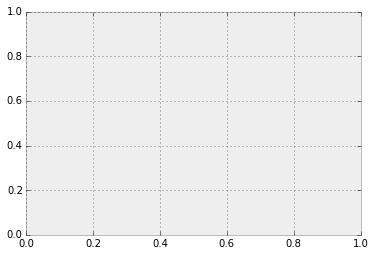

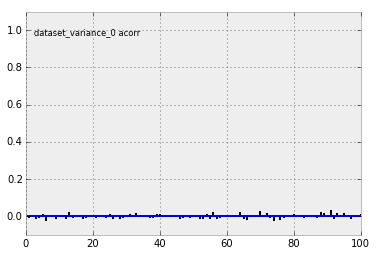

In [4]:
pymc.Matplot.autocorrelation(MDL)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


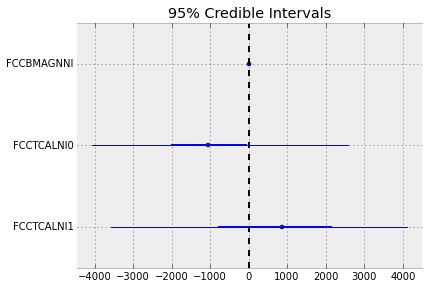

In [5]:
pymc.Matplot.summary_plot(params)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


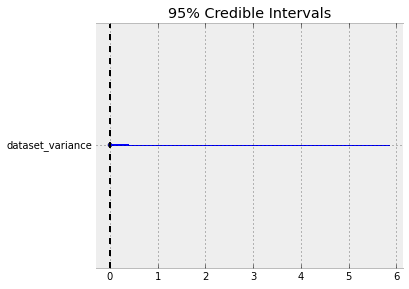

In [6]:
pymc.Matplot.summary_plot(dataset_variance)

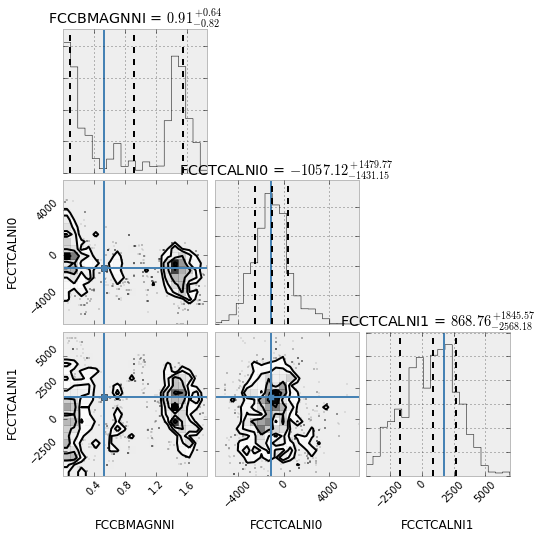

In [37]:
from corner import corner
from itertools import chain
data = np.vstack(chain([i.trace() for i in params])).T
corner(data, labels=[str(i) for i in params],
       quantiles=[0.16, 0.5, 0.84],
       truths=[0.52, -1112, 1745],
       show_titles=True, title_args={"fontsize": 40}).show()

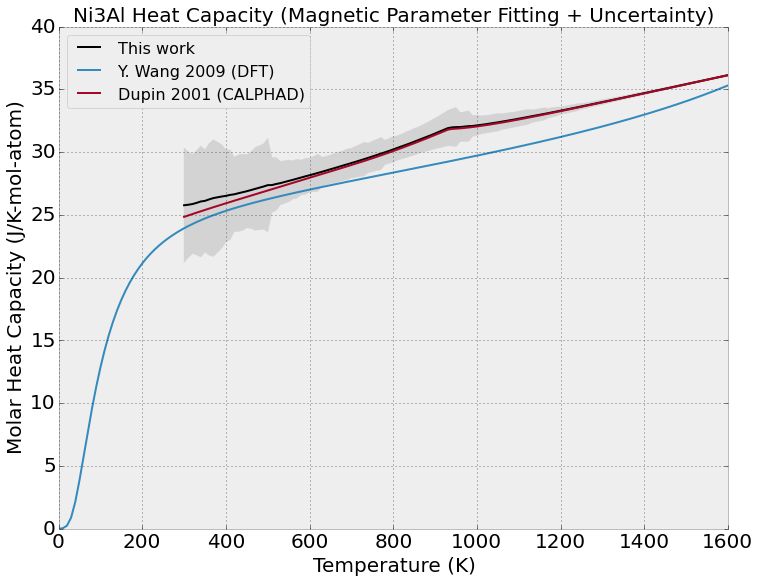

In [31]:
plt.figure(figsize=(12,9))
FCCBMAGNNI_tr, FCCTCALNI0_tr, FCCTCALNI1_tr = [i.trace()[None, None, None].T for i in params]
Cfit = dataset_calc_funcs[0](FCCBMAGNNI_tr, FCCTCALNI0_tr, FCCTCALNI1_tr).sel(T=slice(300, None))
mu = Cfit['CPM'].values.mean(axis=0).flatten()
sigma = 2 * Cfit['CPM'].values.std(axis=0).flatten()
plt.plot(Cfit['T'].values.flatten(), mu, '-k', label='This work')
plt.fill_between(Cfit['T'].values.flatten(), mu - sigma, mu + sigma, color='lightgray')
plt.plot(dataset_exps[0]['T'], dataset_exps[0].values.flatten(), label='Y. Wang 2009 (DFT)')
cp_from_dupin = calculate(Database('Al-Ni/Al-Ni-Dupin-2001.tdb'), ['AL', 'NI', 'VA'], ['FCC_L12'],
                          output='CPM', points=np.array([[0, 1, 1, 0, 1]], dtype=np.float),
                          T=Cfit['T'].values.flatten(), P=101325)
plt.plot(cp_from_dupin['T'].values, cp_from_dupin['CPM'].values.flatten(), label='Dupin 2001 (CALPHAD)')
plt.title('Ni3Al Heat Capacity (Magnetic Parameter Fitting + Uncertainty)', fontsize=20)
plt.xlabel('Temperature (K)', fontsize=20)
plt.ylabel('Molar Heat Capacity (J/K-mol-atom)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='best', fontsize=16)
plt.show()